# Example Usage

Results are still preliminary. This gives a toy example for how to use the code in this repository for model training, inference, and result visualization. Performance is not yet optimized and there are still more validation tests to finish.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from max_deeplab.model import MaXDeepLabS
from max_deeplab.losses import MaXDeepLabLoss
from datasets.coco_panoptic import build
from torch.optim import Adam
from util.misc import collate_fn
from torch.utils.data import DataLoader
from util.visualize import display_instances, random_colors

from einops import rearrange
from matplotlib import pyplot as plt

In [3]:
config = {}
HW = 224
N = 30 #if the loaded image has more than 30 masks, this number must be increased
bsz = 4 #small batch for a toy example; too small for actual model training

config['image_size'] = (HW, HW)
config['coco_path'] = 'coco_panoptic/' #directory with image and annotation data
data = build('train', config)

#dictionary of class names from Coco Panoptic
category_dict = {dct['id']: dct['name'] for dct in data.coco['categories']}
category_dict[201] = 'no_class'

#create a dataloader that collates batch with padding
#see utils.misc.collate_fn
padding_dict = {'image': 0, 'masks': 0, 'semantic_mask': 0, 'labels': 0, 'image_id': 0} #padding values
sizes_dict = {'image': None, 'masks': N, 'semantic_mask': None, 'labels': N, 'image_id': None} #padded sizes
collate_lambda = lambda b: collate_fn(b, padding_dict, sizes_dict)

loader = DataLoader(data, batch_size=bsz, shuffle=True, collate_fn=collate_lambda)

#we will just try to overfit a single batch of images
batch = iter(loader).next()

In [4]:
device = torch.device('cuda:0')
P = batch['image'].to(device)

masks = batch['masks'].to(device)
labels = batch['labels'].to(device)
semantic = batch['semantic_mask'].to(device)
target_tuple = (masks, labels, semantic)

In [5]:
model = MaXDeepLabS(im_size=HW, n_classes=202, n_masks=N).cuda()
criterion = MaXDeepLabLoss().cuda()
optimizer = Adam(model.parameters(), lr=3e-4) #RAdam later, just Adam for testing

In [11]:
for i in range(500):
    optimizer.zero_grad()

    out = model(P)
    loss, loss_items = criterion(out, target_tuple)
    loss.backward()
    optimizer.step()

    if (i + 1) % 50 == 0:
        loss_string = ', '.join([f'{k}: {v}' for k,v in loss_items.items()])
        print(f'epoch {i + 1}: ', loss.item())
        print(loss_string)

epoch 50:  1.682173490524292
pq: 0.30501043796539307, semantic: 0.27461346983909607, maskid: 1.638833999633789, instdisc: 0.0008785012760199606
epoch 100:  1.5873609781265259
pq: 0.28867730498313904, semantic: 0.23233263194561005, maskid: 1.6193283796310425, instdisc: 0.0031980834901332855
epoch 150:  1.5315824747085571
pq: 0.27920132875442505, semantic: 0.21117985248565674, maskid: 1.5939871072769165, instdisc: 0.004602551460266113
epoch 200:  1.4672601222991943
pq: 0.2669040858745575, semantic: 0.19189956784248352, maskid: 1.5785014629364014, instdisc: 0.0010979041690006852
epoch 250:  1.4293173551559448
pq: 0.26130133867263794, semantic: 0.17710646986961365, maskid: 1.5584238767623901, instdisc: 0.0007797120488248765
epoch 300:  1.41011381149292
pq: 0.2625110149383545, semantic: 0.16338127851486206, maskid: 1.5272566080093384, instdisc: 0.0010224684374406934
epoch 350:  1.3710564374923706
pq: 0.25563254952430725, semantic: 0.15208733081817627, maskid: 1.5037212371826172, instdisc: 0

In [20]:
#basic inference
with torch.no_grad():
    out = model(P)

    instance_probs = F.softmax(out[0], dim=1)
    instances = instance_probs.argmax(dim=1)
    instances = F.one_hot(instances, num_classes=N).permute(0, 3, 1, 2)
    
    #filter out pixels by mask id confidence
    #instances[instance_probs < 0.4] = 0
    
    class_confidence, classes = F.softmax(out[1], dim=-1).max(-1)

    semantic = F.softmax(out[2], dim=1).argmax(dim=1)

    #throughout padding instances in gt
    keep_gt_instances = torch.where(batch['labels'].tensors > 0)
    
    #filter out low confidence instances from predictions
    keep_pred_instances = torch.where(torch.logical_and(classes > 0, class_confidence > 0.7))

In [21]:
gt_instances = []
gt_classes = []
gt_class_names = []

pred_instances = []
pred_classes = []
pred_class_names = []

for index in range(bsz):
    keep_gt = keep_gt_instances[1][keep_gt_instances[0] == index]
    keep_pred = keep_pred_instances[1][keep_pred_instances[0] == index]
    
    gt_instances.append(batch['masks'].tensors.detach()[index, keep_gt].cpu().numpy())
    gt_classes.append(batch['labels'].tensors.detach()[index, keep_gt].cpu().numpy())
    gt_class_names.append([category_dict[l] for l in gt_classes[-1]])

    pred_instances.append(instances.detach()[index, keep_pred].cpu().numpy())
    pred_classes.append(classes.detach()[index, keep_pred].cpu().numpy())
    pred_class_names.append([category_dict[l] for l in pred_classes[-1]])

In [22]:
def roll_image(image):
    """helper for displaying images"""
    image = np.rollaxis(image, 0, 3)
    image -= image.min()
    image /= image.max()
    image *= 255
    return image.astype(np.uint8)

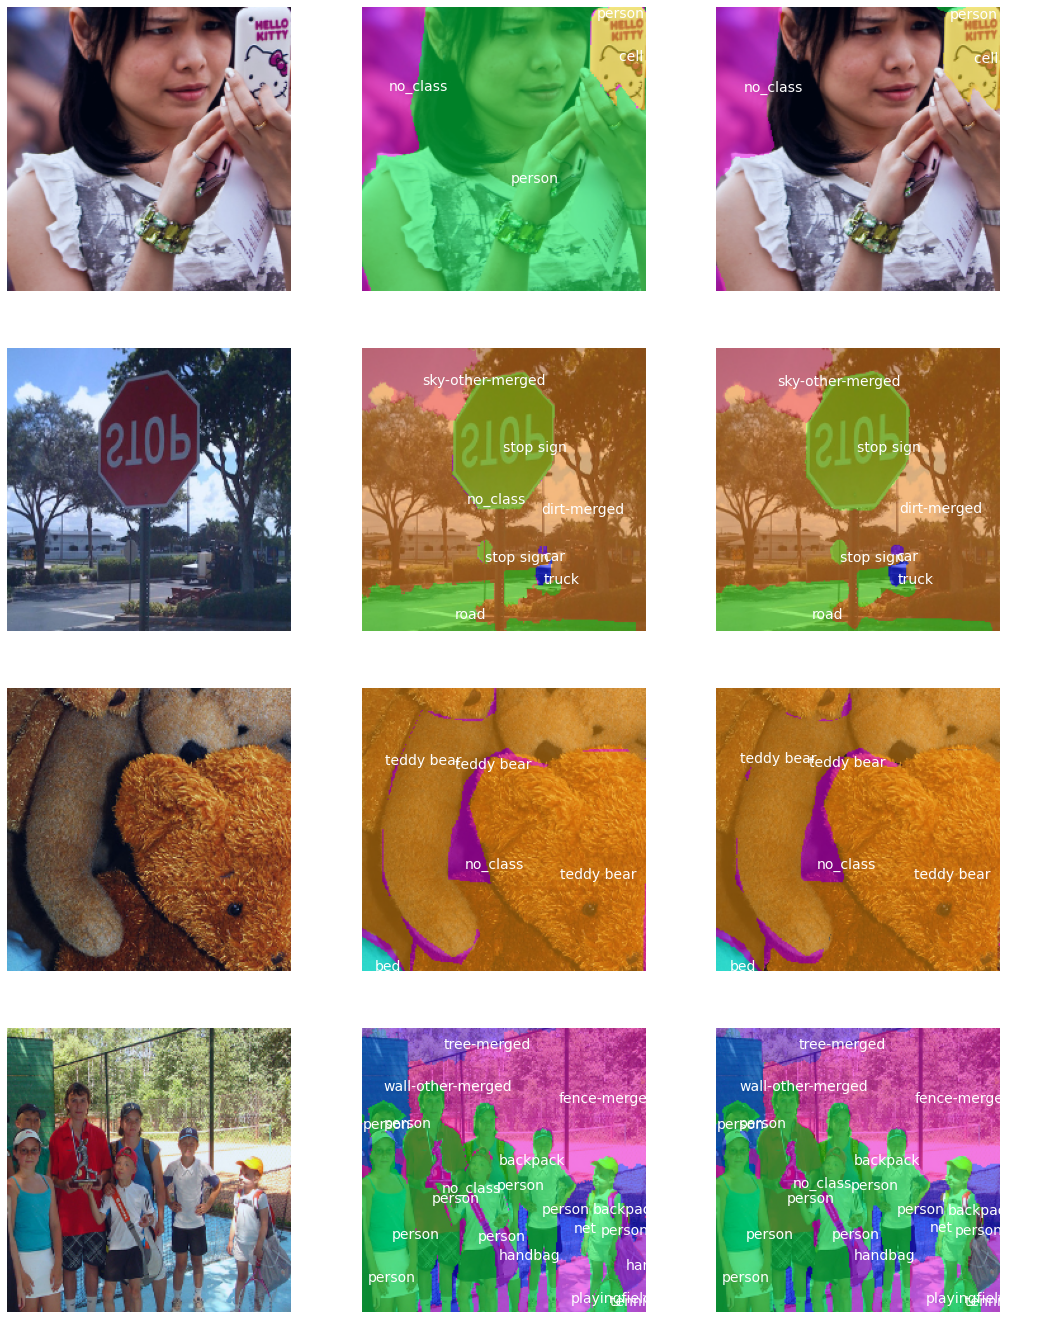

In [24]:
f, ax = plt.subplots(bsz, 3, figsize=(18, 6*bsz), squeeze=False)

colors = random_colors(202)

for index in range(bsz):
    display_image = roll_image(batch['image'].tensors.detach().cpu().numpy()[index])
    ax[index, 0].imshow(display_image)
    ax[index, 0].axis('off')
    display_instances(display_image, gt_instances[index], gt_classes[index], 
                      gt_class_names[index], ax=ax[index, 1], colors=colors)
    display_instances(display_image, pred_instances[index], pred_classes[index], 
                      pred_class_names[index], ax=ax[index, 2], colors=colors)